In [1]:
import numpy as np
#import keras
import tensorflow
from sklearn import metrics
from numpy import mean,std,dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os,csv

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '/device:GPU:0'

In [3]:
# 定义读取数据函数，转换为DataFrame数据结构，返回Numpy数组。
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
# 定义 pandas读取 UCI HAR 数据集中的所有数据的函数；
# 数组的维数为 [样本，时间步长，特征]（[sample，timestamp，features]）
# numpy 的 dstack()方法将输入数据按照第三维堆叠。
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded


In [5]:
# 加载数据集，返回数据集X和标签y
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # 加载所有9个文件转换为一维数组
    filenames = list()
    # 重力加速度信号
    filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt', 'total_acc_z_' + group + '.txt']
    # 身体加速度信号
    filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt', 'body_acc_z_' + group + '.txt']
    # 陀螺仪读取的身体角速度信号
    filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt', 'body_gyro_z_' + group + '.txt']
    # 加载输入数据
    X = load_group(filenames, filepath)
    # 加载分类标记
    y = load_file(prefix + group + '/y_' + group + '.txt')
    return X, y

In [6]:
# 加载数据集，并返回训练集和测试集
def load_dataset(prefix=''):
    # 加载训练数据集
    trainX, trainy = load_dataset_group('train', prefix + 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/')
    print(trainX.shape, trainy.shape)
    # 加载测试数据集
    testX, testy = load_dataset_group('test', prefix + 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/')
    print(testX.shape, testy.shape)
    # 原数据集标签为1到6，而one-hot编码中类别起始序号为0，减去一以使得分类数为6
    trainy = trainy - 1
    testy = testy - 1
    # 使用keras的方法对分类进行one-hot编码
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


In [7]:
# 拟合评估模型
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 100, 64
    # verbose, epochs, batch_size = 1, 5, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    """
    CNN-LSTM模型将主序列的子序列作为块读取，从每个块中提取特征，然后让LSTM来解释从每个块中提取的特征。
    实现此模型的一种方法是将128个时间步长的窗口分割成子序列，以便CNN模型处理。
    例如，每个窗口中的128个时间步可以分成4个32个时间步的子序列。
    """
    n_steps, n_length = 4, 32
    
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    
    # 定义模型
    #model = Sequential() # 顺序模型
    
    # 为了在TF2.1使用tensorboard
    model = tensorflow.keras.Sequential()
    
    
    """
    CNN模型包装在TimeDistributed层中，
    以允许相同的CNN模型在窗口中读取四个子序列中的每个子序列。
    """
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    #  Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
    # 是将一个维度大于或等于3的高维矩阵，“压扁”为一个二维矩阵。即保留第一个维度。
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    # softmax激活函数：本质是离散概率分布，适用于多分类任务。
    model.add(Dense(n_outputs, activation='softmax'))
    
    # 编译模型
    # 交叉熵损失衡量的是实际输出与期望输出的距离，交叉熵的值越小，两个概率分布就越接近。
    # 损失函数：二分类binary_crossentropy,多分类：categorial_crossentropy/sparse_categorical_crossentropy
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 控制台打印网络结构
    print(model.summary())
    
    # 保存网络结构图
    from tensorflow.keras.utils import plot_model
    plot_model(model,to_file='CNN-LSTM-HAR.png',show_shapes=True,dpi=300)
    
    # 构造Tensorboard类的对象
    #summary = tf.keras.callbacks.TensorBoard(log_dir="D:/GraduationCode/02-Jason-HAR-Pandas-9axis-Keras/cnn_lstm_logs/",histogram_freq=1)
    logdir = os.path.join('cnn_lstm_logs')
    summary = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)
    history = model.fit(trainX, trainy, 
                      epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy),
                      callbacks=[summary])
    
    # 模型保存
    model.save('uci_har_cnn-lstm.h5')
    
    # 模型测试
    test_model(model, testX, verbose, batch_size, n_outputs)
    # 模型评估
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)

    model.evaluate(testX, testy, batch_size=batch_size)
    print("model.metrics_names:{}".format(model.metrics_names))
    
    return accuracy,history


In [8]:
# 定义测试模型
def test_model(model, testX, verbose, batch_size, n_outputs):

    prediction_list = model.predict(testX, batch_size=batch_size, steps=None, verbose=verbose)
    predictions_transformed = np.eye(n_outputs, dtype=int)[np.argmax(prediction_list, axis=1)]

    np.savetxt('cnn_lstm_predictions.txt', prediction_list)
    np.savetxt('cnn_lstm_predictions_trans.txt', (np.argmax(predictions_transformed, axis=1)))

In [9]:
def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accurary']
    epochs = range(1, len(acc) + 1)
    plt.figure(dpi=200)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'orange', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

In [10]:
def plot_loss(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(dpi=200)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [11]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [12]:
def plot_predictions():
    x = list(range(1, 101))
    actual = read_csv("D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/y_test.txt", nrows=100, header=None, delim_whitespace=True)
    predicted = read_csv("predictions_trans.txt", nrows=100, header=None, delim_whitespace=True)
    predicted = ([x+1 for x in np.array(predicted)])
    plt.figure(dpi=200)
    plt.plot(x, actual)
    plt.plot(x, predicted, color='r')
    plt.show()

    with open('D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/y_test.txt', newline='') as csvfile:
        actualok = list(csv.reader(csvfile))

    with open('cnn_lstm_predictions_trans.txt', newline='') as csvfile:
        predictedok = list(csv.reader(csvfile))


    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(actualok, predictedok)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
    # Plot Results: 
    width = 8
    height = 8
  
    plt.figure(figsize=(width, height),dpi=200)
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")


    print(normalised_confusion_matrix)

    LABELS = [
        "WALKING", 
        "WALKING_UPSTAIRS", 
        "WALKING_DOWNSTAIRS", 
        "SITTING", 
        "STANDING", 
        "LAYING"
    ]
    plt.colorbar()
    tick_marks = np.arange(6)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [13]:
def run_experiment(repeats=5):
# def run_experiment(repeats=1):
    trainX, trainy, testX, testy = load_dataset()
    #repeat experiment
    scores=list()
    for r in range(repeats):
        score,history = evaluate_model(trainX, trainy, testX, testy)
        score=score*100.0
        print("Accuracy : ", score)
        plot_predictions()
        plot_accuracy(history)
        plot_loss(history)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 896)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               398800    
______________________

Epoch 99/100
7352/7352 [==============================] - 2s 315us/sample - loss: 0.0253 - accuracy: 0.9884 - val_loss: 0.7635 - val_accuracy: 0.8931
Epoch 100/100
2947/2947 [==============================] - 0s 111us/sample - loss: 0.7819 - accuracy: 0.8975
model.metrics_names:['loss', 'accuracy']
Accuracy :  89.75229263305664


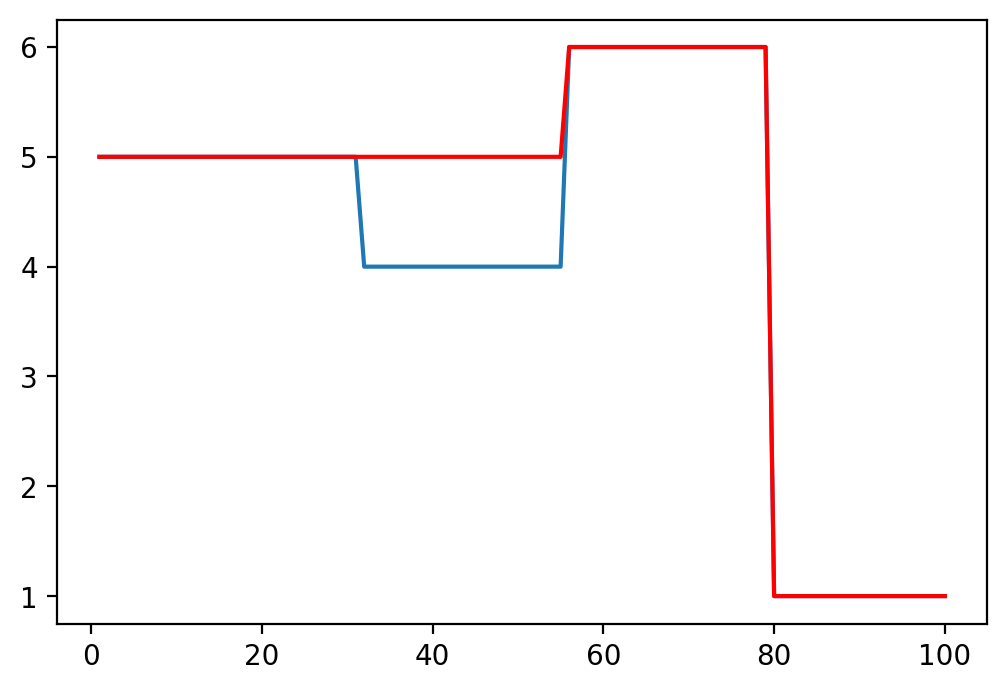

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [490   0   0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [ 28   0 417   0  26   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0   1   0 414   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  25   0   0   0 360   0 106   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0  76   0 454   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  27   0   0   0   0   0   0   0 510   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.627077    0.          0.          0.          0.20359688  0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

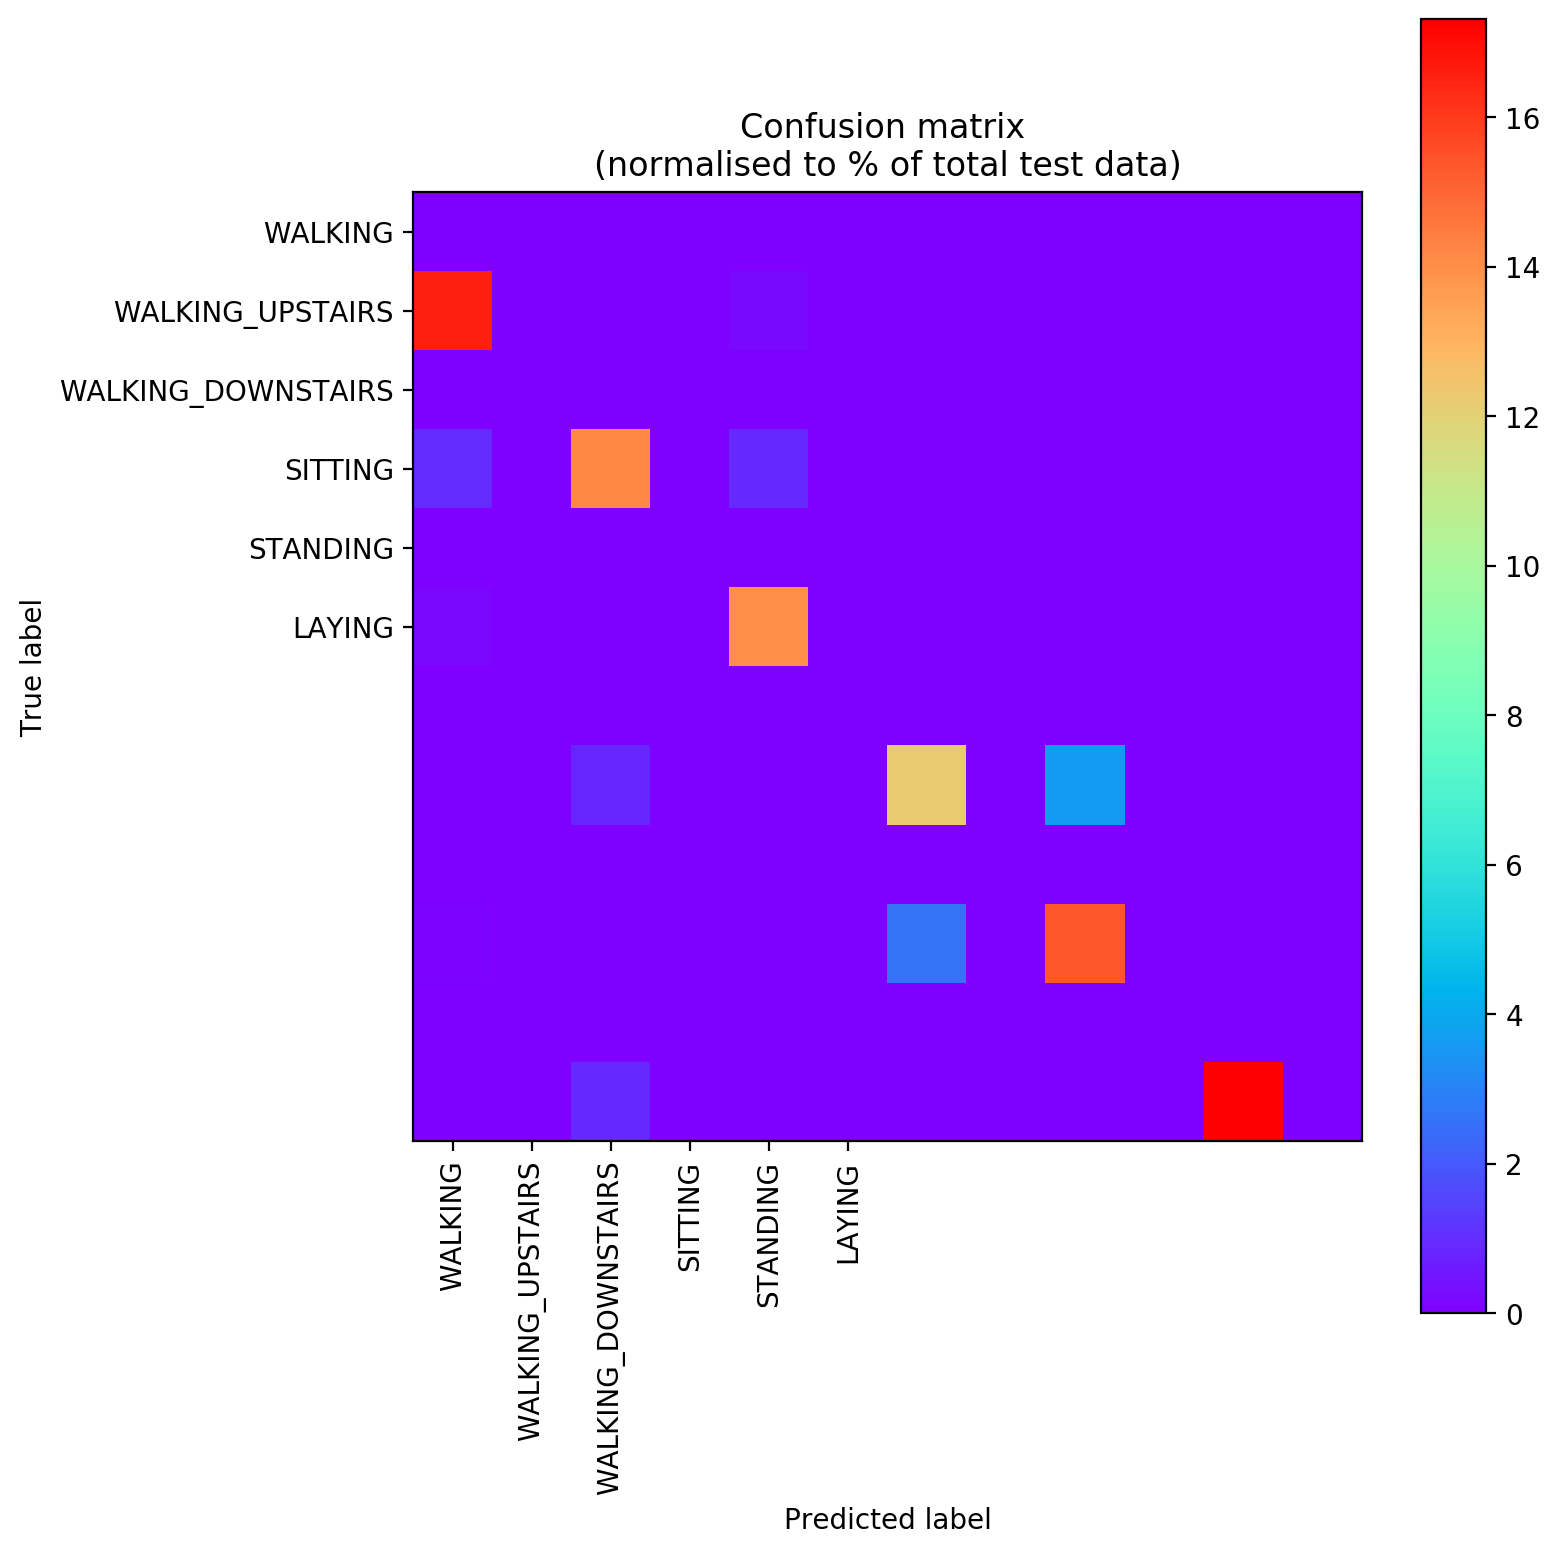

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 896)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)              

7352/7352 [==============================] - 2s 313us/sample - loss: 0.0458 - accuracy: 0.9752 - val_loss: 0.4852 - val_accuracy: 0.9080
Epoch 46/100
7352/7352 [==============================] - 2s 314us/sample - loss: 0.0465 - accuracy: 0.9765 - val_loss: 0.6269 - val_accuracy: 0.9043
Epoch 47/100
7352/7352 [==============================] - 2s 313us/sample - loss: 0.0427 - accuracy: 0.9782 - val_loss: 0.7161 - val_accuracy: 0.8870
Epoch 48/100
7352/7352 [==============================] - 2s 320us/sample - loss: 0.0404 - accuracy: 0.9782 - val_loss: 0.6934 - val_accuracy: 0.9002
Epoch 49/100
7352/7352 [==============================] - 2s 322us/sample - loss: 0.0406 - accuracy: 0.9784 - val_loss: 0.6351 - val_accuracy: 0.9186
Epoch 50/100
7352/7352 [==============================] - 2s 311us/sample - loss: 0.0467 - accuracy: 0.9765 - val_loss: 0.4499 - val_accuracy: 0.9114
Epoch 51/100
7352/7352 [==============================] - 2s 320us/sample - loss: 0.0430 - accuracy: 0.9789 - val

Epoch 100/100
2947/2947 [==============================] - 0s 111us/sample - loss: 0.7350 - accuracy: 0.9131
model.metrics_names:['loss', 'accuracy']
Accuracy :  91.31320118904114


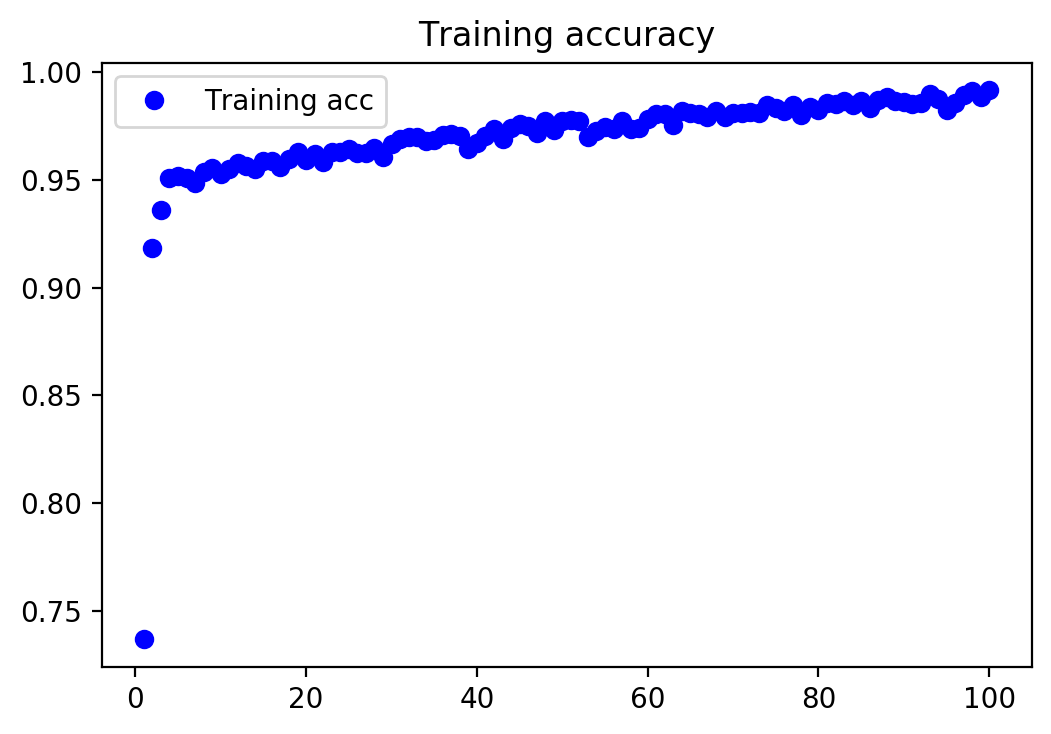

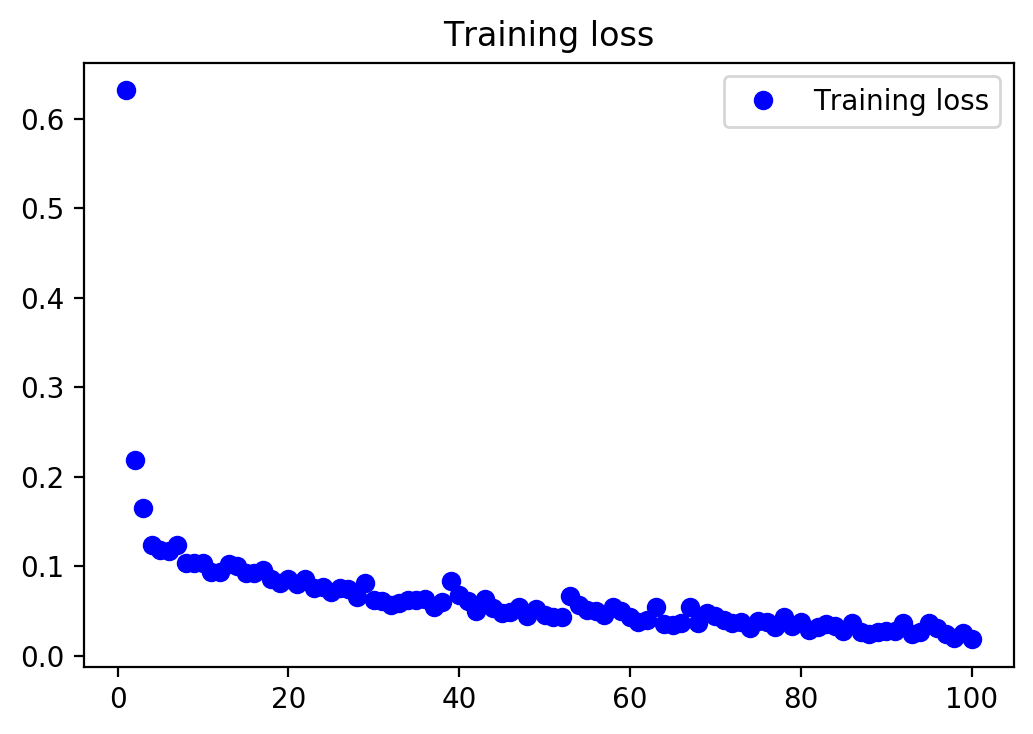

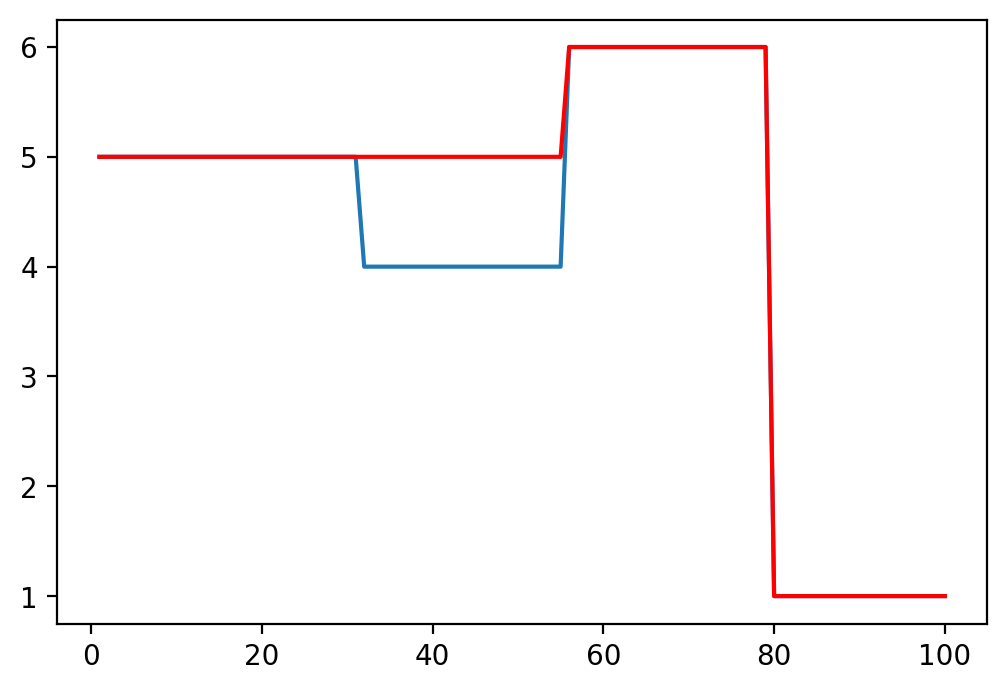

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [466   0   0   0  30   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0 444   0  25   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   2   0 416   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0 383   0  98   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0  59   0 472   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  27   0   0   0   0   0   0   0 510   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [15.812691    0.          0.          0.          1.0179844   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

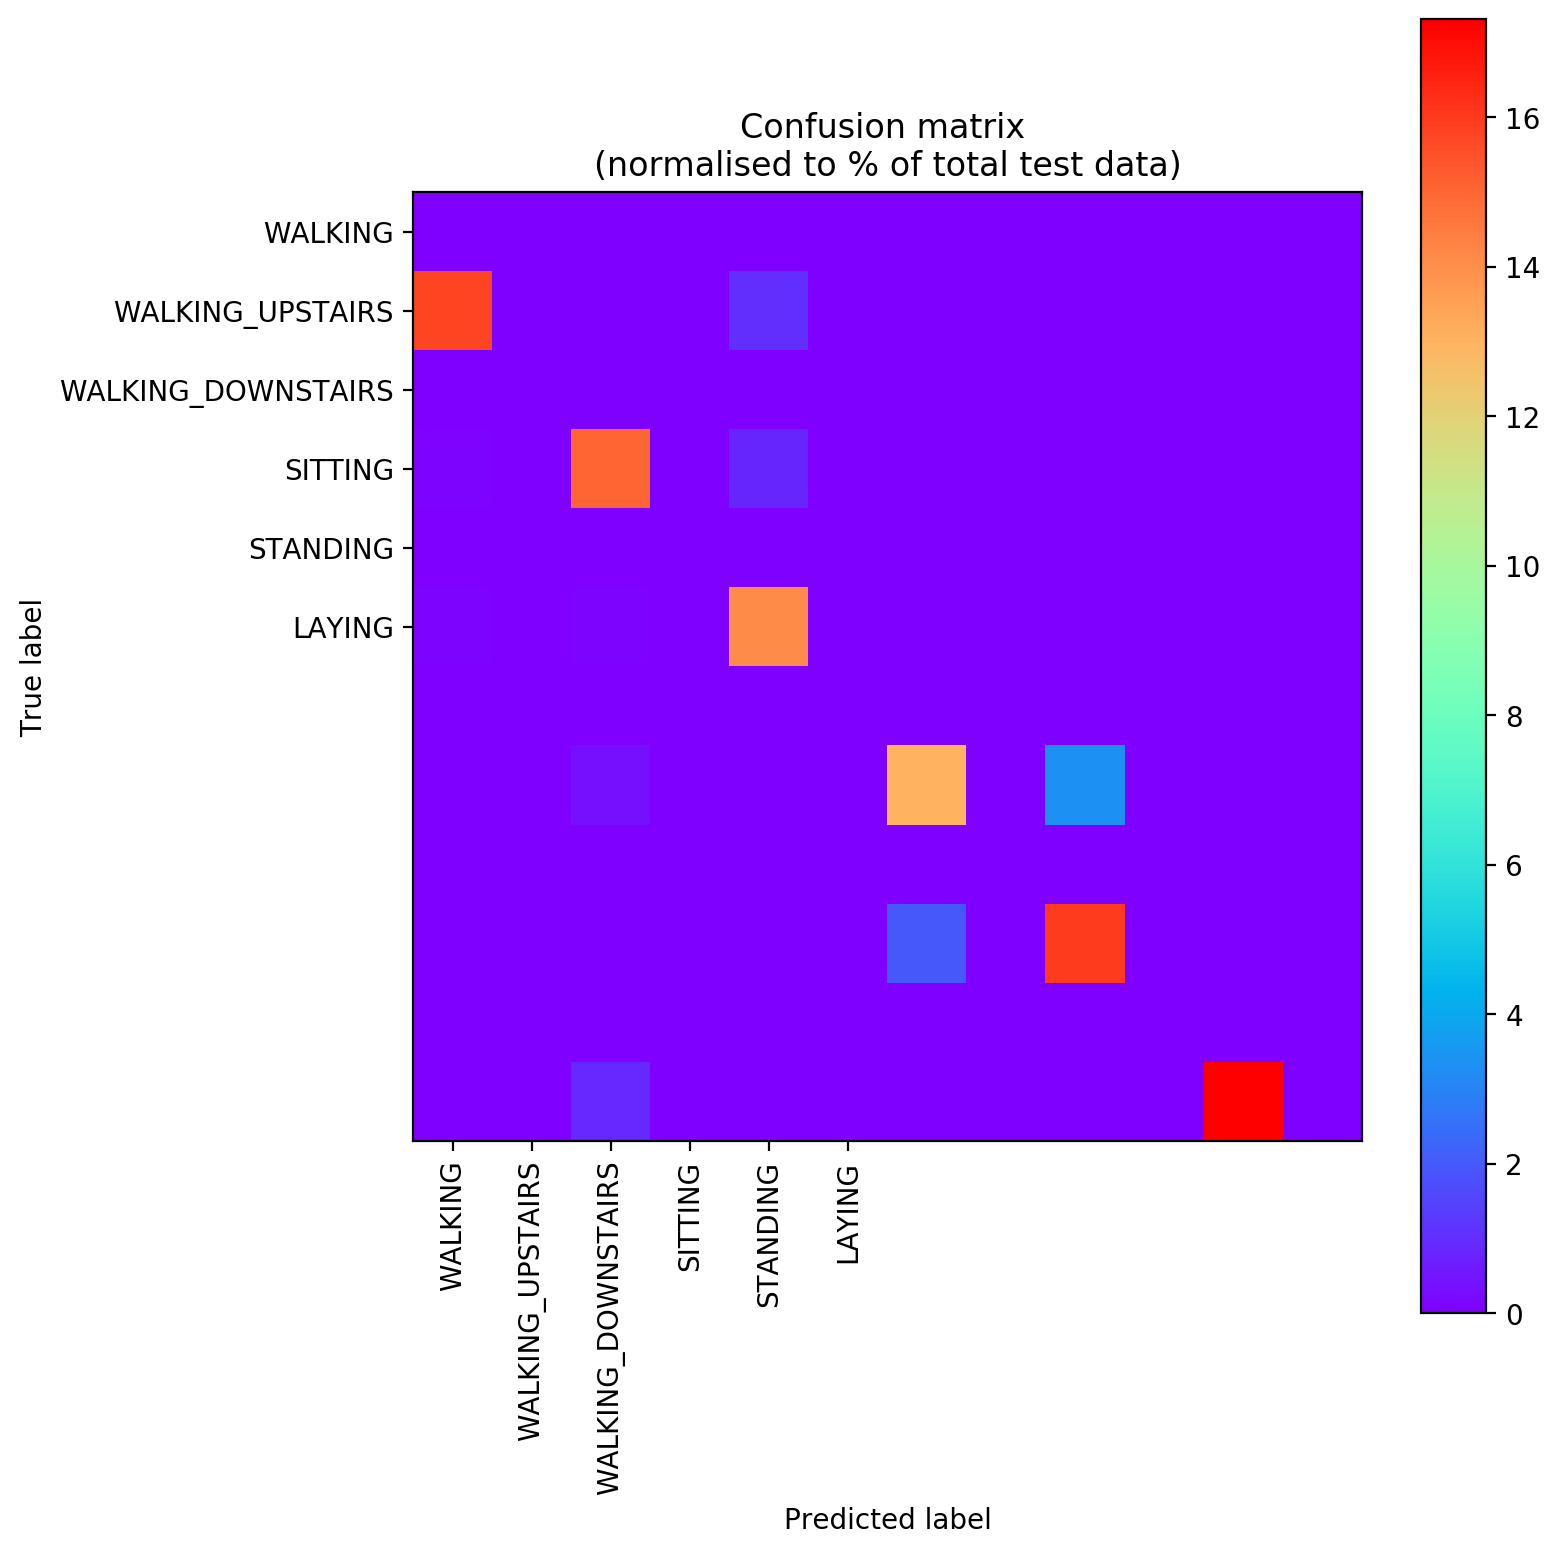

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)              

7352/7352 [==============================] - 2s 312us/sample - loss: 0.0507 - accuracy: 0.9755 - val_loss: 0.8650 - val_accuracy: 0.8521
Epoch 46/100
7352/7352 [==============================] - 2s 314us/sample - loss: 0.0596 - accuracy: 0.9716 - val_loss: 0.4476 - val_accuracy: 0.9186
Epoch 47/100
7352/7352 [==============================] - 2s 312us/sample - loss: 0.0549 - accuracy: 0.9731 - val_loss: 0.4871 - val_accuracy: 0.9084
Epoch 48/100
7352/7352 [==============================] - 2s 312us/sample - loss: 0.0432 - accuracy: 0.9785 - val_loss: 0.5009 - val_accuracy: 0.9152
Epoch 49/100
7352/7352 [==============================] - 2s 309us/sample - loss: 0.0460 - accuracy: 0.9766 - val_loss: 0.4720 - val_accuracy: 0.9016
Epoch 50/100
7352/7352 [==============================] - 2s 316us/sample - loss: 0.0390 - accuracy: 0.9792 - val_loss: 0.4052 - val_accuracy: 0.9053
Epoch 51/100
7352/7352 [==============================] - 2s 317us/sample - loss: 0.0488 - accuracy: 0.9757 - val

Epoch 100/100
2947/2947 [==============================] - 0s 109us/sample - loss: 0.3724 - accuracy: 0.9362
model.metrics_names:['loss', 'accuracy']
Accuracy :  93.62063407897949


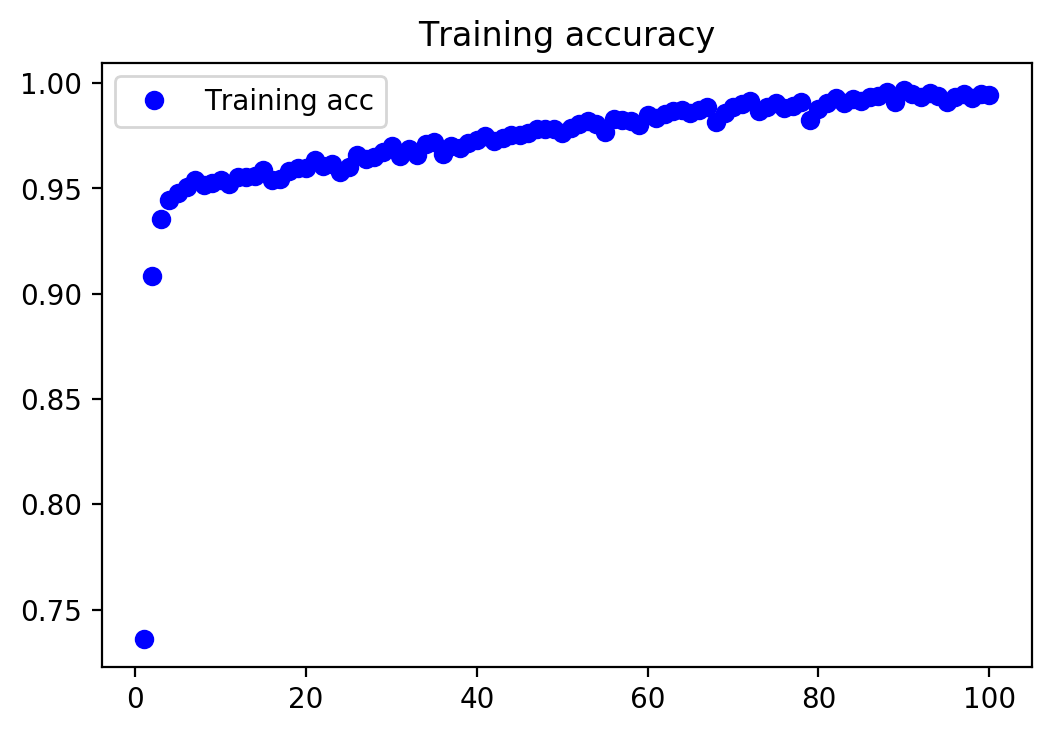

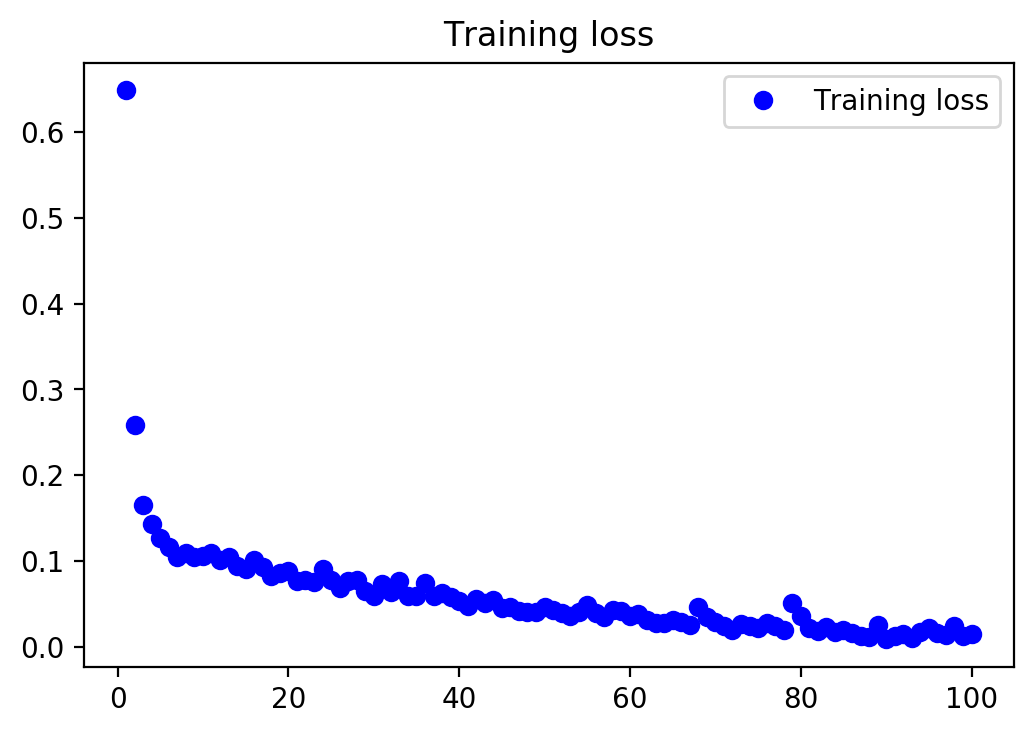

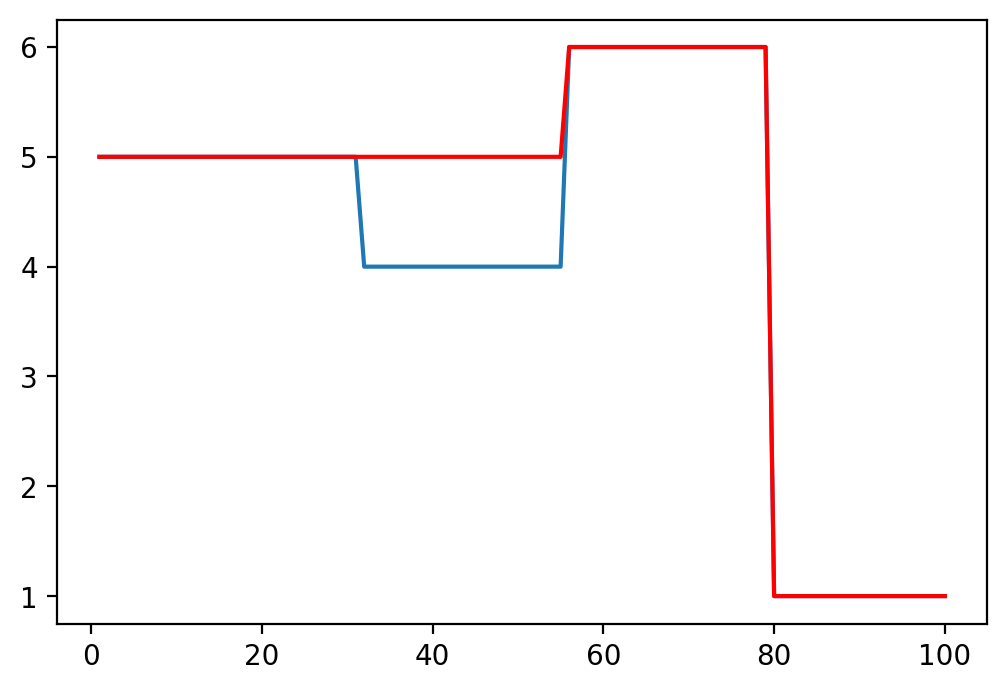

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [485   0   0   0  11   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 450   0  21   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   1   0 417   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   3   0   0   0 399   0  84   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  61   0 471   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 537   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.457415    0.          0.          0.          0.37326095  0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

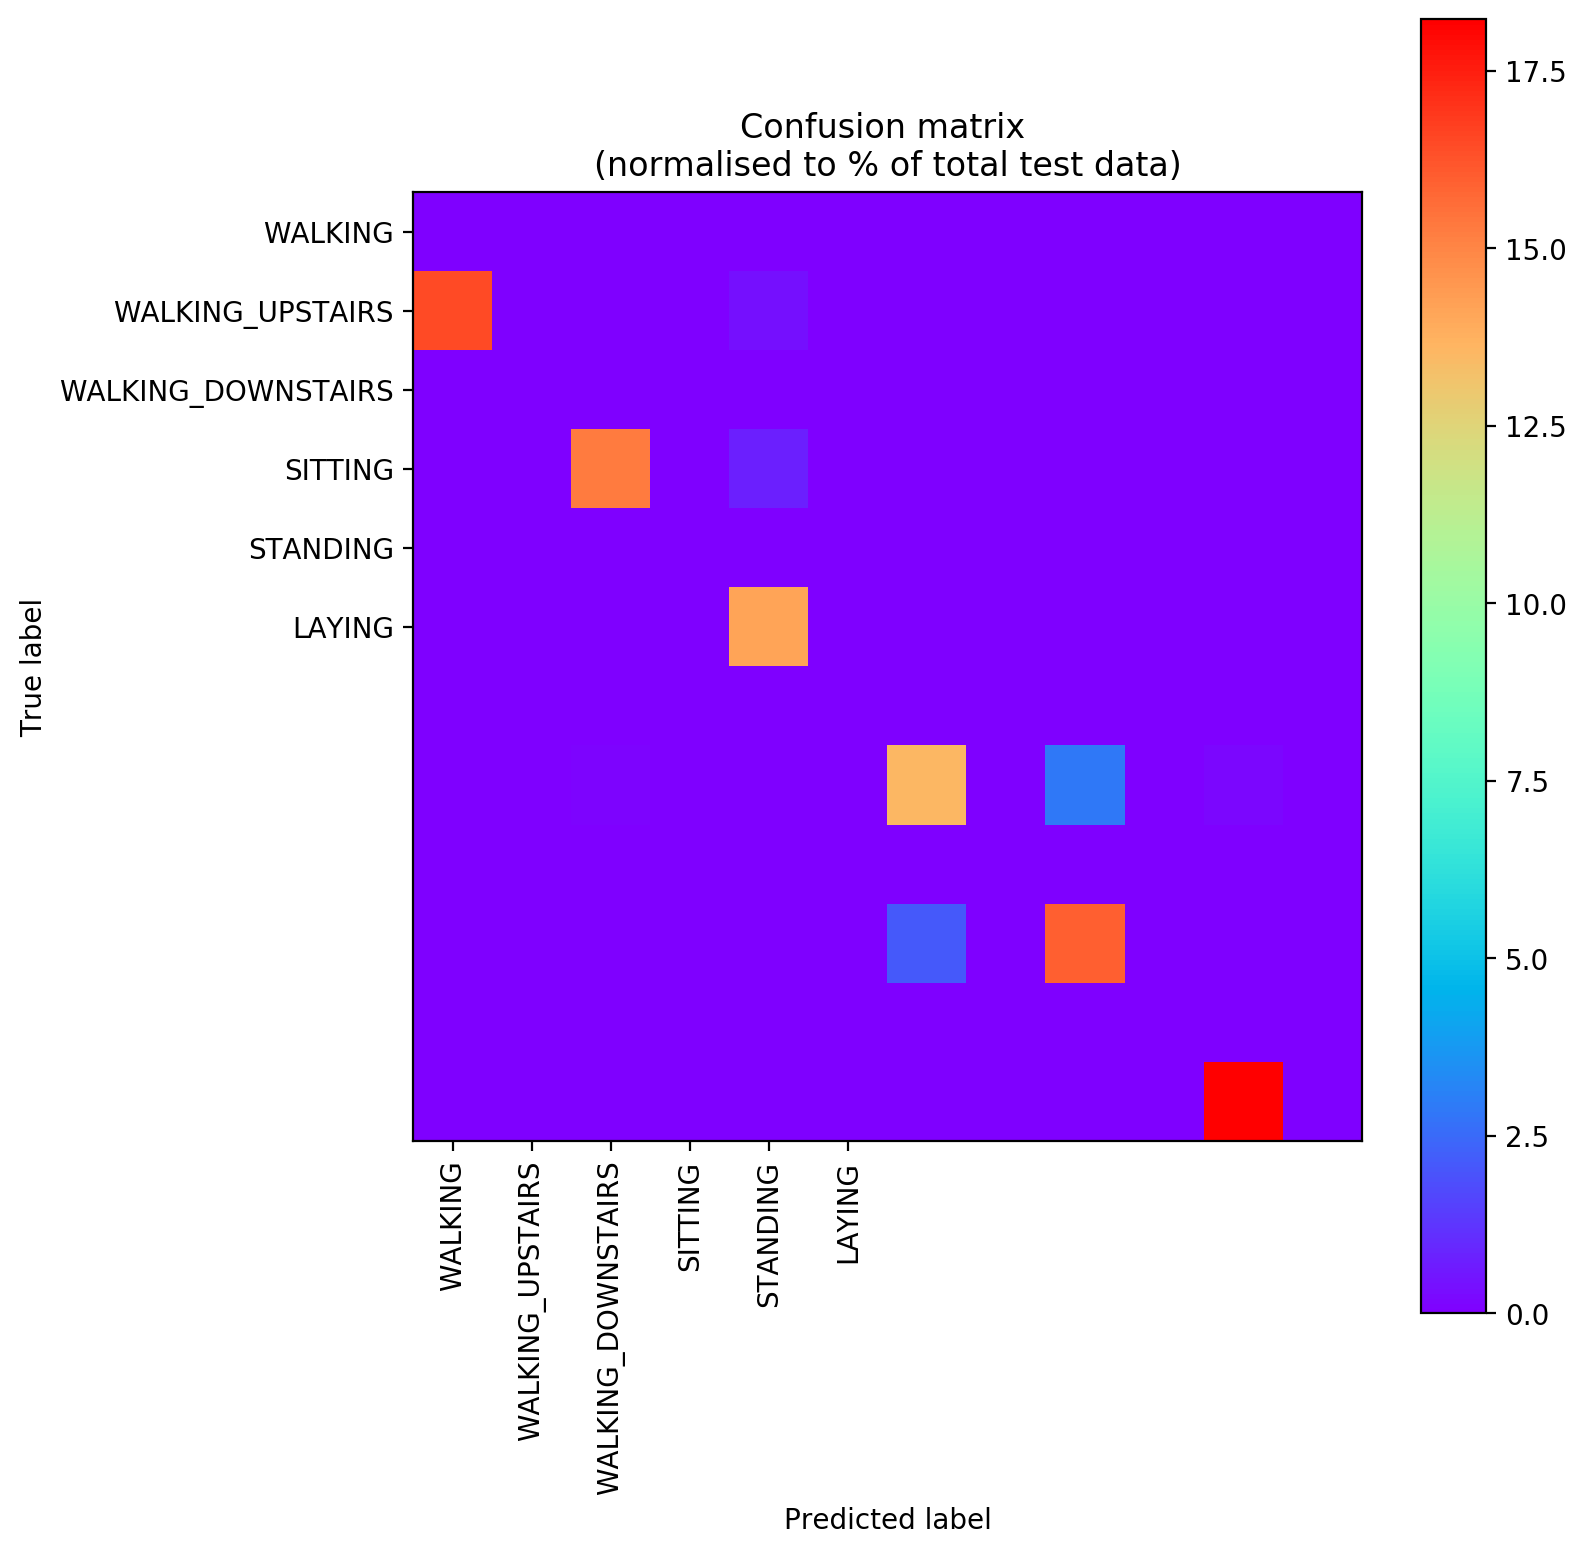

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)              

7352/7352 [==============================] - 2s 305us/sample - loss: 0.0396 - accuracy: 0.9816 - val_loss: 0.4785 - val_accuracy: 0.9080
Epoch 46/100
7352/7352 [==============================] - 2s 307us/sample - loss: 0.0457 - accuracy: 0.9788 - val_loss: 0.5578 - val_accuracy: 0.9104
Epoch 47/100
7352/7352 [==============================] - 2s 307us/sample - loss: 0.0360 - accuracy: 0.9825 - val_loss: 0.5124 - val_accuracy: 0.9223
Epoch 48/100
7352/7352 [==============================] - 2s 305us/sample - loss: 0.0307 - accuracy: 0.9867 - val_loss: 0.5316 - val_accuracy: 0.9206
Epoch 49/100
7352/7352 [==============================] - 2s 304us/sample - loss: 0.0313 - accuracy: 0.9868 - val_loss: 0.5819 - val_accuracy: 0.8941
Epoch 50/100
7352/7352 [==============================] - 2s 304us/sample - loss: 0.0504 - accuracy: 0.9796 - val_loss: 0.4073 - val_accuracy: 0.9175
Epoch 51/100
7352/7352 [==============================] - 2s 304us/sample - loss: 0.0316 - accuracy: 0.9852 - val

Epoch 100/100
2947/2947 [==============================] - 0s 112us/sample - loss: 0.3221 - accuracy: 0.9376
model.metrics_names:['loss', 'accuracy']
Accuracy :  93.75635981559753


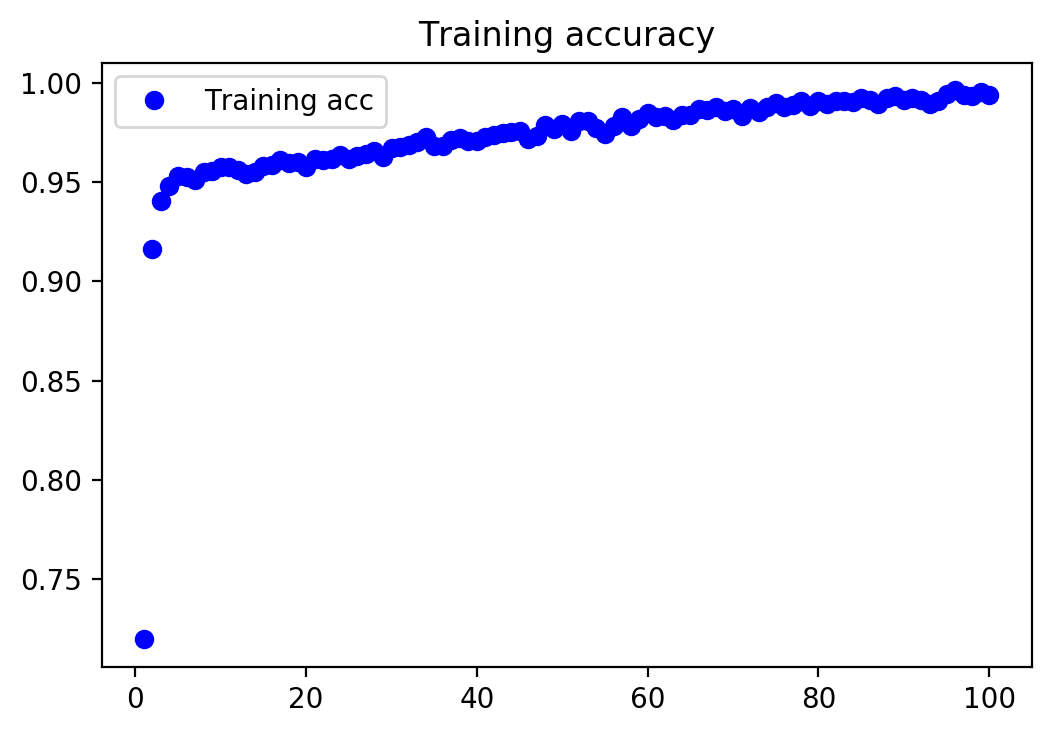

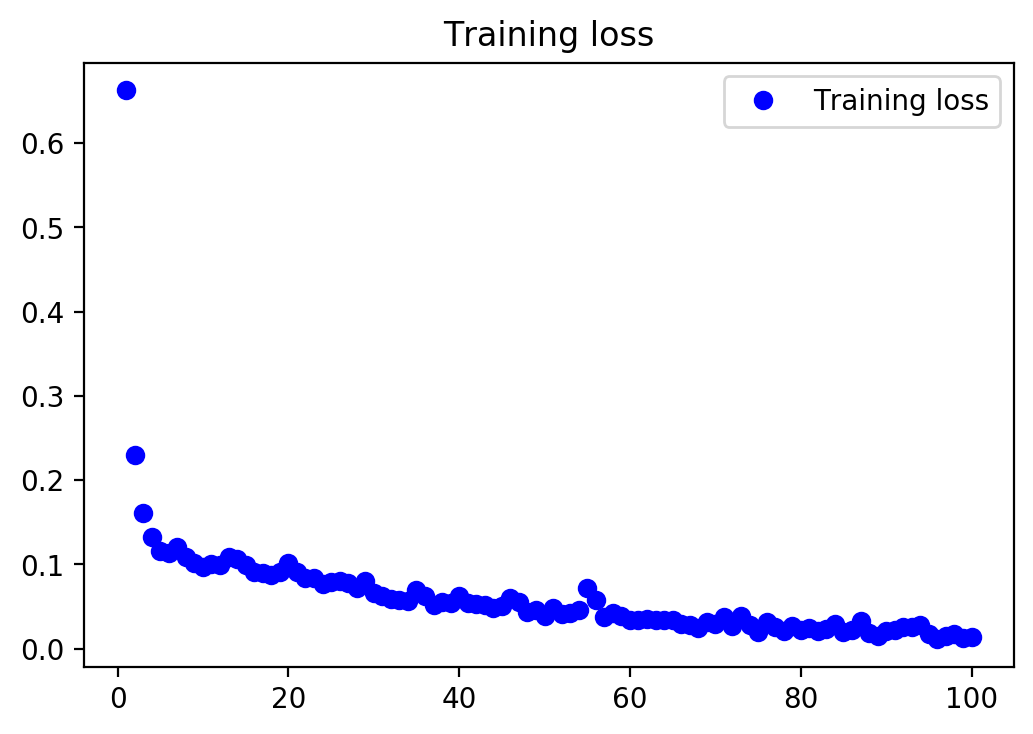

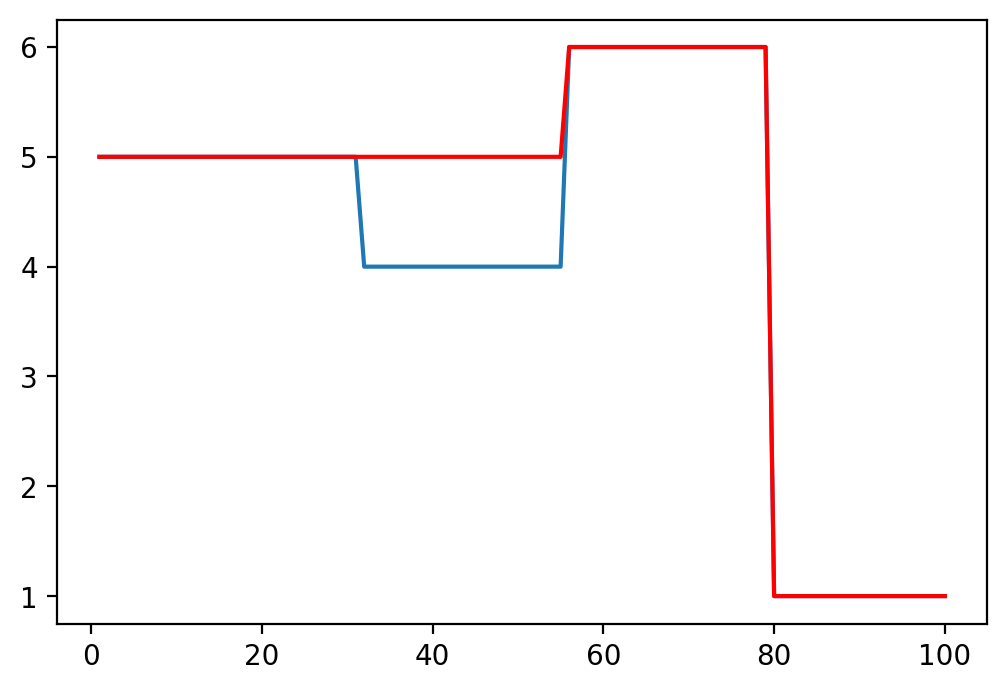

Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [486   0   3   0   7   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0 445   0  24   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  3   0   0   0 417   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   4   0   0   0 390   0  92   0   5   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  44   0 488   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 537   0]]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [16.491348    0.          0.10179844  0.          0.2375297   0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.    

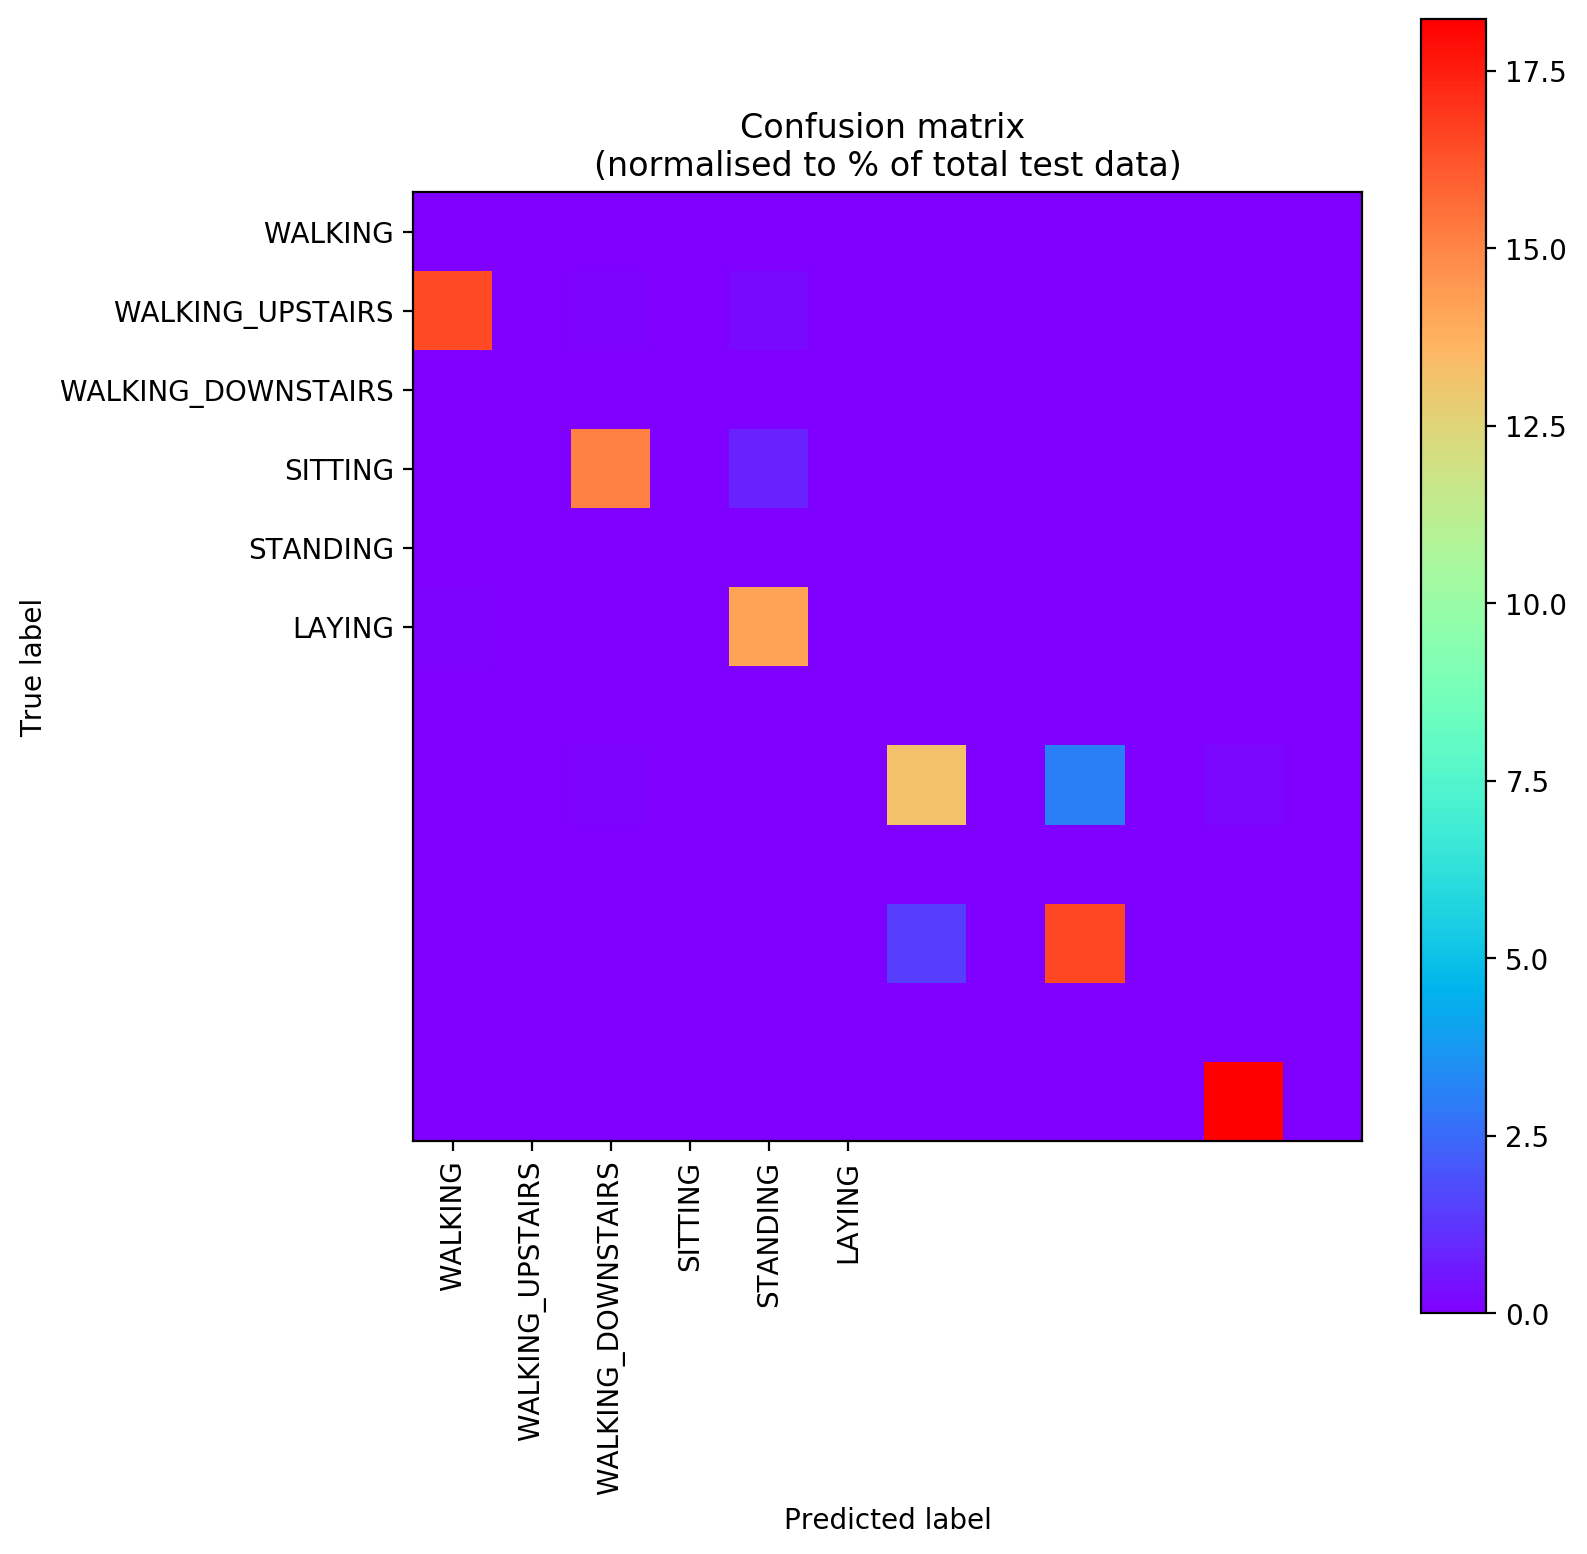

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, None, 896)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               398800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)              

In [ ]:
run_experiment()

In [ ]:
import pandas as pd
df = pd.read_csv('predictions_trans.txt', sep=" ", header=None, names=["Prediction"])
temp_dict={0:'Walking',
           1:'Walking-upstairs',
           2:'Walking-downstairs',
           3:'Sitting',
           4:'Standing',
           5:'Laying'}

df['Prediction']=df.Prediction.map(temp_dict)
df

In [ ]:
df.to_csv(r'cnn_lstm_activity_predictions.txt', header=None, index=None, sep='\t', mode='a')